In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import sys

ROOT = os.path.dirname(os.getcwd())
sys.path.append(ROOT)
ROOT

'/Users/louisecolumelli/Documents/karl/RL-solitaire/rl-solitaire'

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
from pytorch_lightning import seed_everything
import torch

from utils.tools import load_pickle, read_yaml
from env.env import Env

In [63]:
AGENT_NAME = 'actor_critic'
NETWORK_NAME = 'fc_policy_value'
RUN_NAME = '2024_02_19-11_24' #'2024_02_18-19_34' # '2024_02_16-16_24' # '2024_02_16-16_24' # '2024_02_16-14_13'
SEED = 42

run_dir = os.path.join(ROOT, 'agents', AGENT_NAME, 'runs', RUN_NAME)
network_config_filename = f"{AGENT_NAME}_config.yaml"
seed_everything(seed=SEED)

Seed set to 42


42

In [64]:
results_path = os.path.join(run_dir, 'agent_results.pickle')
all_results = load_pickle(results_path, single=False)

In [65]:
len(all_results)

12000

In [66]:
reward_means = []
reward_stds = []
pegs_means = []
pegs_stds = []
for i in range(len(all_results)):
    results_i = all_results[i]
    rewards = results_i["rewards"]
    pegs_left = results_i["pegs_left"]

    reward_means.append(np.mean(rewards))
    reward_stds.append(np.std(rewards))

    pegs_means.append(np.mean(pegs_left))
    pegs_stds.append(np.std(pegs_left))

reward_means = np.array(reward_means)
reward_stds = np.array(reward_stds)
pegs_means = np.array(pegs_means)
pegs_stds = np.array(pegs_stds)

# Agent Results

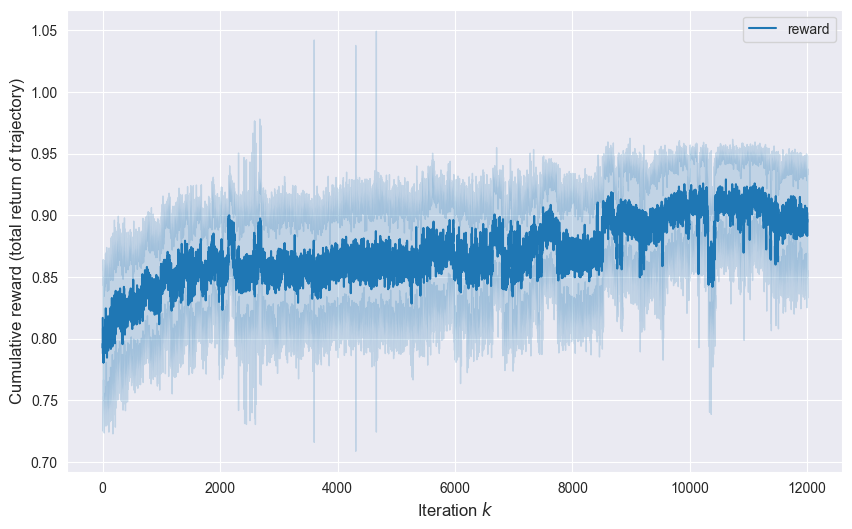

In [67]:
figsize = (10, 6)
scale = 1.0
fontsize = 12
color = sns.color_palette()[0]

plt.figure(figsize=figsize)
iteration_number = np.arange(len(reward_means))
plt.plot(iteration_number, reward_means, label='reward', color=color)
plt.fill_between(iteration_number, reward_means - scale * reward_stds, reward_means + scale * reward_stds, color=color, alpha = 0.2)
plt.xlabel('Iteration $k$', fontsize=fontsize)
plt.ylabel('Cumulative reward (total return of trajectory)', fontsize=fontsize)
plt.legend()
plt.show()

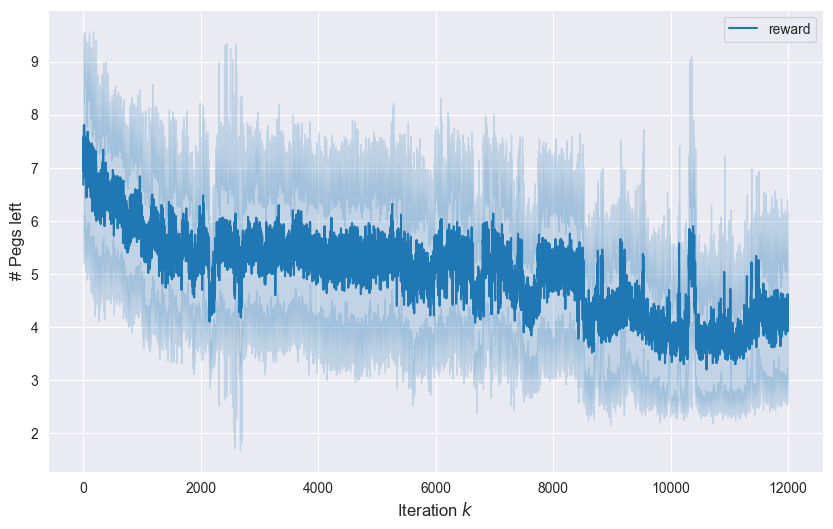

In [68]:
figsize = (10, 6)
scale = 1.0
fontsize = 12
color = sns.color_palette()[0]

plt.figure(figsize=figsize)
iteration_number = np.arange(len(pegs_means))
plt.plot(iteration_number, pegs_means, label='reward', color=color)
plt.fill_between(iteration_number, pegs_means - scale * pegs_stds, pegs_means + scale * pegs_stds, color=color, alpha = 0.2)
plt.xlabel('Iteration $k$', fontsize=fontsize)
plt.ylabel('# Pegs left', fontsize=fontsize)
plt.legend()
plt.show()

In [69]:
np.min(pegs_means)

3.2

In [70]:
np.max(reward_means)

0.9290322580645156

In [71]:
np.argmax(reward_means)

10614

In [72]:
all_rewards = [r for res in all_results for r in res['rewards']]
print(len(all_rewards))
print(np.max(all_rewards))
print(np.min(all_rewards))

600000
1.9677419354838703
0.1935483870967742


In [73]:
all_pegs = [r for res in all_results for r in res['pegs_left']]
print(len(all_pegs))
print(np.max(all_pegs))
print(np.min(all_pegs))

600000
26
1


In [77]:
np.sum(all_pegs[all_pegs == 1])

7

In [79]:
np.sort(os.listdir(path=os.path.join(run_dir, 'checkpoints')))

array(['epoch=10201_step=85493.ckpt', 'epoch=10501_step=88123.ckpt',
       'epoch=10801_step=90823.ckpt', 'epoch=11101_step=93521.ckpt',
       'epoch=11401_step=96213.ckpt', 'epoch=11701_step=98904.ckpt',
       'epoch=11989_step=101500.ckpt', 'epoch=12000_step=101591.ckpt',
       'epoch=1201_step=9618.ckpt', 'epoch=1501_step=12043.ckpt',
       'epoch=1801_step=14469.ckpt', 'epoch=1_step=8.ckpt',
       'epoch=2101_step=16934.ckpt', 'epoch=2401_step=19431.ckpt',
       'epoch=2701_step=21919.ckpt', 'epoch=3001_step=24348.ckpt',
       'epoch=301_step=2408.ckpt', 'epoch=3301_step=26786.ckpt',
       'epoch=3601_step=29217.ckpt', 'epoch=3901_step=31643.ckpt',
       'epoch=4201_step=34111.ckpt', 'epoch=4501_step=36596.ckpt',
       'epoch=4801_step=39075.ckpt', 'epoch=5101_step=41537.ckpt',
       'epoch=5401_step=43986.ckpt', 'epoch=5701_step=46529.ckpt',
       'epoch=6001_step=49099.ckpt', 'epoch=601_step=4808.ckpt',
       'epoch=6301_step=51578.ckpt', 'epoch=6601_step=54061.ckpt

In [100]:
#checkpoint_name = 'epoch=4000_step=33290'
# checkpoint_name = 'epoch=1601_step=12810'
# checkpoint_name = 'epoch=4000_step=33290'
checkpoint_name = 'epoch=12000_step=101591.ckpt'

# Load and evaluate agent from checkpoint

In [101]:
from agents.actor_critic.actor_critic_agent import ActorCriticAgent
from nn.policy_value.fully_connected import FCPolicyValueNet
from nn.network_config import NetConfig

In [102]:
# set and net config
network_config_filename = f"{NETWORK_NAME}_config.yaml"
network_config_dict = read_yaml(os.path.join(run_dir, network_config_filename))

network_config = NetConfig(config_dict=network_config_dict)
#network = FCPolicyValueNet(network_config)

In [103]:
checkpoint_path = os.path.join(run_dir, 'checkpoints', checkpoint_name)
network = FCPolicyValueNet.load_from_checkpoint(checkpoint_path, config=network_config)

In [104]:
agent_name = f"ActorCriticAgent-{network.name}"
agent = ActorCriticAgent(network=network, name=agent_name)

In [105]:
n_games_eval = 1000
agent.set_evaluation_mode()
env = Env()
env.reset()

with torch.no_grad():
    rewards, pegs_left = agent.evaluate(env, n_games=n_games_eval, greedy=False)
    greedy_reward, greedy_pegs = agent.evaluate(env, greedy=True)
    greedy_reward = greedy_reward[0]
    greedy_pegs = greedy_pegs[0]

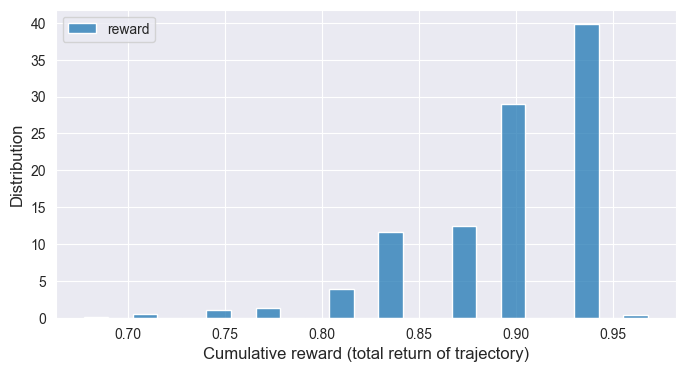

In [106]:
figsize = (8, 4)
scale = 1.0
fontsize = 12

plt.figure(figsize=figsize)
#sns.histplot(data=rewards, stat='probability')
sns.histplot(data=rewards, stat='percent', label='reward')

plt.xlabel('Cumulative reward (total return of trajectory)', fontsize=fontsize)
plt.ylabel('Distribution', fontsize=fontsize)
plt.legend()
plt.show()


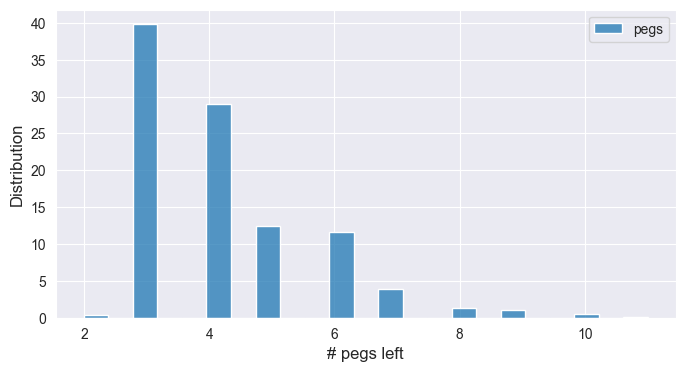

In [107]:
figsize = (8, 4)
scale = 1.0
fontsize = 12

plt.figure(figsize=figsize)
#sns.histplot(data=rewards, stat='probability')
sns.histplot(data=pegs_left, stat='percent', label='pegs')
# sns.histplot(data=pegs_left, stat='percent', label='pegs', bins=12)

plt.xlabel('# pegs left', fontsize=fontsize)
plt.ylabel('Distribution', fontsize=fontsize)
plt.legend()
plt.show()


In [108]:
print(np.mean(rewards))
print(np.mean(pegs_left))

0.8965806451612898
4.206


In [109]:
print(greedy_reward)
print(greedy_pegs)

0.9354838709677413
3


In [88]:
print(np.mean(rewards))
print(np.mean(pegs_left))

0.9133548387096769
3.686


In [89]:
print(greedy_reward)
print(greedy_pegs)

0.9354838709677413
3


In [39]:
print(np.mean(rewards))
print(np.mean(pegs_left))

0.8775806451612898
4.795


In [40]:
print(greedy_reward)
print(greedy_pegs)

0.9032258064516123
4


In [49]:
print(np.mean(rewards))
print(np.mean(pegs_left))

0.8757096774193542
4.853


In [50]:
print(greedy_reward)
print(greedy_pegs)

0.8387096774193543
6


In [59]:
print(np.mean(rewards))
print(np.mean(pegs_left))

0.8799354838709672
4.722


In [60]:
print(greedy_reward)
print(greedy_pegs)

0.8387096774193543
6


In [110]:
s = set([1, 2, 3])
s.add(5)

In [111]:
s

{1, 2, 3, 5}

In [113]:
s.remove(1)
s

{2, 3, 5}

In [114]:
s.discard(4)

In [116]:
x_ = torch.randn(32, 7, 7, 3)
y_ = torch.flatten(x_, start_dim=1, end_dim=2)
print(x_.shape)
print(y_.shape)

torch.Size([32, 7, 7, 3])
torch.Size([32, 49, 3])


In [117]:
lin_ = torch.nn.Linear(in_features=3, out_features=128, bias=True)
lin_.forward(y_).shape

torch.Size([32, 49, 128])

In [118]:
y_

tensor([[[ 0.8838, -0.2692, -0.0455],
         [ 1.1473,  2.3011, -0.2441],
         [ 1.6936, -1.0099, -0.1295],
         ...,
         [ 0.2950, -0.1388, -0.7514],
         [-0.6728,  0.1258,  0.4022],
         [-0.6023, -0.0232, -0.6114]],

        [[ 1.0467,  0.2466,  0.3512],
         [ 0.0057,  0.6329, -0.2480],
         [-0.6811, -1.0732,  0.7896],
         ...,
         [ 0.6678,  2.3866,  0.0641],
         [ 0.4544, -1.9388,  0.3476],
         [ 1.0121,  3.2105,  0.6997]],

        [[-1.1726, -0.5416,  0.3788],
         [-0.6406, -0.4636,  2.5578],
         [ 1.6166, -0.3980,  0.9327],
         ...,
         [ 1.0314,  0.0536,  0.9164],
         [-0.3527, -0.1375, -0.6099],
         [ 0.3820,  0.9912, -0.2719]],

        ...,

        [[ 0.8350, -0.4128, -0.5997],
         [ 1.4210, -0.3164,  0.2849],
         [ 0.5419,  1.7325, -0.7811],
         ...,
         [-0.5691, -0.3639,  0.1746],
         [-1.1344, -0.8628,  1.4595],
         [ 0.1408,  0.6875, -0.0076]],

        [[

In [121]:
y_[:, 0, 0::2]

tensor([[ 0.8838, -0.0455],
        [ 1.0467,  0.3512],
        [-1.1726,  0.3788],
        [ 1.4808,  0.0541],
        [ 0.7352,  0.4015],
        [ 2.0471,  0.6268],
        [-1.9338,  1.4750],
        [-0.0695,  0.0876],
        [ 0.0307, -0.5616],
        [-1.5674,  1.4555],
        [-0.9010,  0.9188],
        [ 0.1552,  2.5912],
        [-0.3963, -0.4507],
        [ 0.0248,  1.2286],
        [ 1.5103, -0.1672],
        [ 0.3195, -0.8059],
        [-0.0841, -0.5949],
        [-0.7415,  0.0196],
        [-0.5402,  1.3166],
        [ 1.0986, -1.2178],
        [ 0.0950, -0.0029],
        [-0.5511, -0.0284],
        [ 1.9106, -0.9675],
        [ 0.5042,  1.2460],
        [-0.2036, -0.5358],
        [ 0.0514,  0.0486],
        [-0.7238,  0.1243],
        [-0.3019, -0.4911],
        [ 0.9937,  0.4800],
        [ 0.8350, -0.5997],
        [ 0.9050, -0.2713],
        [-0.0562, -1.3130]])

In [122]:
y_[:, 0, 0:2]

tensor([[ 0.8838, -0.2692],
        [ 1.0467,  0.2466],
        [-1.1726, -0.5416],
        [ 1.4808,  1.4617],
        [ 0.7352,  0.9137],
        [ 2.0471, -1.8148],
        [-1.9338, -0.1941],
        [-0.0695,  1.4257],
        [ 0.0307,  1.0580],
        [-1.5674,  0.0661],
        [-0.9010, -0.4449],
        [ 0.1552,  0.6024],
        [-0.3963,  0.0457],
        [ 0.0248, -1.7507],
        [ 1.5103, -0.6904],
        [ 0.3195,  0.0742],
        [-0.0841, -1.2419],
        [-0.7415,  0.6126],
        [-0.5402,  0.2946],
        [ 1.0986, -0.2066],
        [ 0.0950,  0.9536],
        [-0.5511, -1.6403],
        [ 1.9106, -0.5415],
        [ 0.5042, -0.3807],
        [-0.2036,  0.0705],
        [ 0.0514,  1.0776],
        [-0.7238, -1.4020],
        [-0.3019,  0.0687],
        [ 0.9937,  0.8381],
        [ 0.8350, -0.4128],
        [ 0.9050,  0.3154],
        [-0.0562, -0.1708]])

In [124]:
a_ = np.array([[1, 2, 3, 4, 5, 6, 7, 8], 
               [1, 2, 3, 4, 5, 6, 7, 9],
               [1, 2, 3, 4, 5, 6, 7, 10]])
a_

array([[ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 1,  2,  3,  4,  5,  6,  7,  9],
       [ 1,  2,  3,  4,  5,  6,  7, 10]])

In [126]:
a_[:, [True, False, True, True, False, True, False, True]]

array([[ 1,  3,  4,  6,  8],
       [ 1,  3,  4,  6,  9],
       [ 1,  3,  4,  6, 10]])

In [127]:
model = torch.nn.Module()


In [128]:
model.add_module("linear1", torch.nn.Linear(in_features=10, out_features=20, bias=True))

In [129]:
model.linear1

Linear(in_features=10, out_features=20, bias=True)

In [130]:
x_.shape

torch.Size([32, 7, 7, 3])

In [131]:
x_[0, 0, 0, :].repeat((10, 1))

tensor([[ 0.8838, -0.2692, -0.0455],
        [ 0.8838, -0.2692, -0.0455],
        [ 0.8838, -0.2692, -0.0455],
        [ 0.8838, -0.2692, -0.0455],
        [ 0.8838, -0.2692, -0.0455],
        [ 0.8838, -0.2692, -0.0455],
        [ 0.8838, -0.2692, -0.0455],
        [ 0.8838, -0.2692, -0.0455],
        [ 0.8838, -0.2692, -0.0455],
        [ 0.8838, -0.2692, -0.0455]])